# Nuwa 0.1.0 Guide

A deep learning framework powered by Zixing by using only numpy, aims to build a deep learning framework to compute partial differential equations with higher performance. This project is still in early development stage, and the underlying development of fully connected neural network. A dynamic back propagation graph is provided, it supports all latest optimizer, normalizations. The second phase will improve the project of the first phase to adapt it to the needs of computing partial differential equations. Finally, the Nuwa framework will be deployed as a C++ project and support CUDA and parallel computing. If you are interested in approving the deep learning framework calculation efficiency, you can contact me by my mail: zixing.qiu@etu.toulouse-inp.fr


## Step 0 Prepare training set
Prepare toy training set
x1 and x2 should be our features and formed as matrix X
theta1 and theta2 are the parameters that we have to match

In [1]:
from __future__ import print_function

import matplotlib.pyplot as plt
import numpy as np

# total observation number
n = 1000
# x1, x2 are generated by two
x1 = np.random.uniform(0, 1, n)
x2 = np.random.uniform(0, 1, n)
const = np.ones(n)
eps = np.random.normal(0, .05, n)
b = 1.5
theta1 = 2
theta2 = 5
Theta = np.array([b, theta1, theta2])
y = np.array(b * const + theta1 * x1 + theta2 * x2 + eps)
y = np.reshape(y, (-1, 1))
X = np.array([const, x1, x2]).T


## Step 1 Dataset and training management
In this toy example, we use Dataset class to manage training data or validation set, batch size and distribute new size sets. We also need to import necessary modules for this example from Nuwa framework

Initiate dataset, set x and y as features and labels, the kwarg shuffle=True allows Dataset shuffle training, test and validation set every time generate new sets.

Nuwa.network, Nuwa.loss, Nuwa.optimizers provides tools which manage network creating, loss evaluation and optimize weights.

In [2]:
from Nuwa.dataloader import Dataset
from Nuwa.network import NN, Linear
from Nuwa.loss import Quadratic, MSE
from Nuwa.optimizers import SGD, Adam, lrdecay
from Nuwa.utils import plotloss
from Nuwa.process import Session
%matplotlib inline

# dataset
dataset = Dataset(X, y, shuffle=True, mini_batch=64)


## Step 2 Network
The easiest way to uild a 5 layers network is to create a list, in which contains 5 Linear class with specified input and output dimension. There are various activation functions to be chosen in Nuwa, you can assign each layer an activation layer and batch normalization while build network.

In [3]:
# build a fully-connected network
layer_list = [Linear(3, 10, 'ReLU', BN=True),
              Linear(10, 100, 'ReLU', BN=True),
              Linear(100, 10, 'ReLU', BN=True),
              Linear(10, 1)]
nn = NN(layer_list)


## Step 3 Loss function
Quadratic class is son class of Ottergrad's Func class. Func class, during back propagation, can calculate automatic differentiation. Choose Loss functions or construct your own function (be present later) Loss function can also add, devide or other calculation.

In [4]:
criterion = Quadratic()

## Step 4: Set optimizer
Adam is always been suggested as the first try of loss function. In the end of training process, optim will update model's weights by their gradient.

In [5]:
optim = Adam()

## Step 5 Begin training
The basic structure of training is:

    for range in epoch number:

        1 use current weight to predict

        2 calculate loss

        3 backpropagation of loss function

        4 optimize model's weights

        5 set gradient of passer and weights as 0

        loop


epoch:  0 ,loss:  14.173039 , lr:  0.01
epoch:  10 ,loss:  9.147735 , lr:  0.01


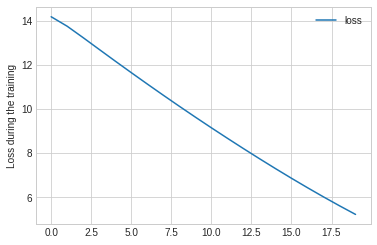

In [6]:
loss_list =[]
for epoch in range(20):
    y_pred = nn(dataset.getftr())

    loss = criterion(y_pred, dataset.getlabel())
    loss_list.append(loss.getroot().getdata())
    lr = lrdecay(1e-2, epoch, decay_rate=0)
    if epoch % 10 == 0:
        print("epoch: ", epoch, ",loss: ", loss.getroot().getdata(), ", lr: ", lr)
    loss.backward()
    optim(nn.getweights(), lr=lr)
    optim.zero_grad(loss)
plotloss(loss_list)

## Note
The previous Session class provides session control which make the training process easier. It takes dataset, nn, optim and loss_func as inputs, Instead of a giant loop, you can set loop parameters in session class.

################# begin 0 epoch #################
epoch:  0 ,loss:  5.134534 , lr:  0.0001
################# begin 1 epoch #################
epoch:  1 ,loss:  5.060237 , lr:  9.999990000010002e-05
################# begin 2 epoch #################
epoch:  2 ,loss:  4.93741 , lr:  9.999980000040001e-05
################# begin 3 epoch #################
epoch:  3 ,loss:  4.767962 , lr:  9.999970000090001e-05
################# begin 4 epoch #################
epoch:  4 ,loss:  4.554558 , lr:  9.999960000160002e-05


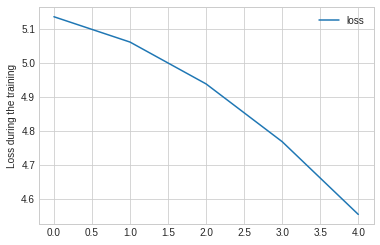

In [7]:
session = Session(dataset=dataset, nn=nn, optim=optim, loss_func=criterion, epoch=5, lr=1e-4, decay_rate=1e-6, mini_batch=64, pretrained=None)
session.start()

## PINN
PINN: Physics-informed neural networks: A deep learning
framework for solving forward and inverse problems involving
nonlinear partial differential equations

M. Raissi, P. Perdikaris, G.E. Karniadakis
Division of Applied Mathematics, Brown University, Providence, RI, 02912, USA
Department of Mechanical Engineering and Applied Mechanics, University of Pennsylvania, Philadelphia, PA, 19104, USA

mat is Schrodinger equation's Runge–Kutta method result. x, t are the features, u, v are the real part and the imaginary part. h  = [u ** 2 + v ** 2]

PINN seperates the iniitial condition, inner and boundary set, each set has different evaluation criteria.

In [8]:
import scipy.io

mat = scipy.io.loadmat('../testdata/mat/NLS.mat')

# mesh grid axis
x = mat['x'].flatten()[:,None]
t = mat['tt'].flatten()[:,None]

# label u, v and h
exact = mat['uu']
u = np.real(exact)
v = np.imag(exact)
h = np.sqrt(u ** 2 + v ** 2)

def getboundaryset(x, u, v, t, sample_size=1, mini_batch=1):
    x_b = np.repeat(x[[0, -1]], t.shape[0])
    u_b = np.concatenate((u[0, :], u[-1, :]), axis=0)
    v_b = np.concatenate((v[0, :], v[-1, :]), axis=0)
    return Dataset(np.concatenate((x_b[:, None], np.tile(t, 2).flatten()[:, None]), axis=1),
                   np.concatenate((u_b[:, None], v_b[:, None]), axis=1), proportion=sample_size, mini_batch=mini_batch)

def getinnerset(x, u, v, t, sample_size=1, mini_batch=1):
    u_in = u[1: -1, 1: -1].flatten()
    v_in = v[1: -1, 1: -1].flatten()
    x_in = np.tile(x[1: -1], t.shape[0] - 2).flatten()
    t_in = np.repeat(t[1: -1], x.shape[0] - 2)
    return Dataset(np.concatenate((x_in[:, None], t_in[:, None]), axis=1),
                   np.concatenate((u_in[:, None], v_in[:, None]), axis=1), proportion=sample_size, mini_batch=mini_batch)

def getinitset(x, u, v, t, sample_size=1, mini_batch=1):
    # initial data
    t0 = np.zeros(x.shape[0])
    u0 = u[:, 0]
    v0 = v[:, 0]
    return Dataset(np.concatenate((x, t0[:, None]), axis=1),
                   np.concatenate((u0[:, None], v0[:, None]), axis=1), proportion=sample_size, mini_batch=mini_batch)


Training process of PINN dataset is more or less the same as the toy example, instead of using only one criterion, PINN use same model with same weights in initial condition set, inner set and boundary set. Loss function of PINN is the summation of these three's MSE loss.Training process still be the same, but, every epoch it need to evaluate three loss function and sum the total loss: loss_total = loss_inner + loss_init + loss_boundary

In [9]:
# datasets
set_init = getinitset(x, u, v, t, mini_batch=128)
set_inner = getinnerset(x, u, v, t, mini_batch=25273)
set_boundary = getboundaryset(x, u, v, t, mini_batch=201)

# network
layer_list = [Linear(2, 10, 'sigmoid', BN=False),
              Linear(10, 20, 'sigmoid', BN=False),
              Linear(20, 50, 'sigmoid', BN=False),
              Linear(50, 100, 'sigmoid', BN=True),
              Linear(100, 100, 'sigmoid', BN=False),
              Linear(100, 100, 'sigmoid', BN=True),
              Linear(100, 50, 'sigmoid', BN=False),
              Linear(50, 20, 'sigmoid', BN=False),
              Linear(20, 10, 'sigmoid', BN=False),
              Linear(10, 2)]
nn = NN(layer_list)

# loss function
criterion = Quadratic()

# optimiser
optim = Adam()

epoch:  0 ,loss:  1.1461127 , lr:  0.02
epoch:  1 ,loss:  0.8285222 , lr:  0.02


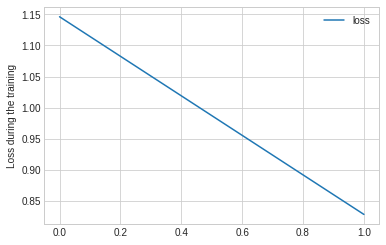

In [10]:
#training
loss_list =[]

for epoch in range(2):

    miniset_init = set_init.getminiset()
    miniset_inner = set_inner.getminiset()
    miniset_boundary = set_boundary.getminiset()
    epoch_loss_list = []

    for i in range(2):

        pred_inner = nn(miniset_inner[i].getftr())
        pred_init = nn(miniset_init[i].getftr())
        pred_boundary = nn(miniset_boundary[i].getftr())

        loss_inner = criterion(pred_inner, miniset_inner[i].getlabel())
        loss_init = criterion(pred_init, miniset_init[i].getlabel())
        loss_boundary = criterion(pred_boundary, miniset_boundary[i].getlabel())
        loss_total = loss_inner + loss_init + loss_boundary

        epoch_loss_list.append(loss_total.getroot().getdata())
        lr = lrdecay(2e-2, epoch, decay_rate=0)

        loss_total.backward()
        optim(nn.getweights(), lr=lr)
        optim.zero_grad(loss_total)

    loss_list.append(np.mean(epoch_loss_list))
    if epoch % 1 == 0:
            print("epoch: ", epoch, ",loss: ", loss_list[-1], ", lr: ", lr)

plotloss(loss_list)

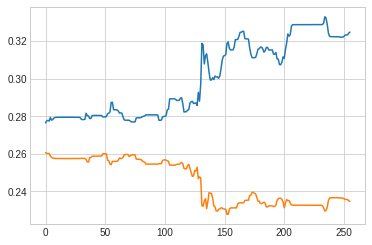

In [11]:
plt.plot(nn(set_init.getftr()).getdata())

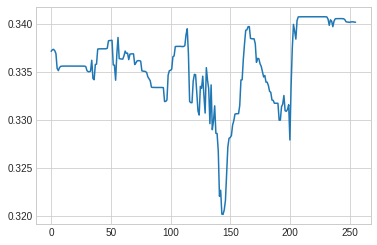

In [12]:
plt.plot(nn(set_init.getftr()).getdata()[0:, 0] ** 2 + nn(set_init.getftr()).getdata()[0:, 1])


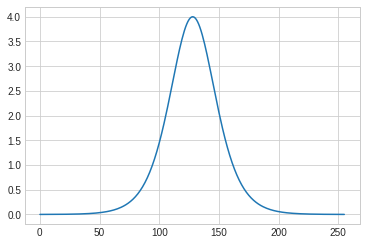

In [13]:
plt.plot(set_init.getlabel().getdata()[0:, 0] ** 2 + set_init.getlabel().getdata()[0:,1] ** 2)